In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from pylab import rcParams
rcParams['figure.figsize'] = 16,8

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

import os
from glob import glob

In [3]:
companies = ["AMAZON", "APPLE", "META", "GOOGLE", "NETFLIX"]
frequency = "daily"
path = os.getcwd()

files = glob(f"/diploma_info/data/*_{frequency}.csv")
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')

In [4]:
columns = ['open_price', 'highest_price', 'lowest_price', 'close_price', 'adj_close_price', 'volume']

meta = pd.read_csv(
    files[2], 
    parse_dates=['Date'],
    date_parser=dateparse,
    index_col=['Date']
)
meta.columns = columns
meta.index.name = 'date'

C:\Users\Admin\AppData\Local\Temp\ipykernel_9520\892827597.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  meta = pd.read_csv(


In [5]:
meta['year'] = meta.index.year
meta['month'] = meta.index.month
meta['day'] = meta.index.day
meta['day_of_week'] = meta.index.weekday
meta['week_of_year'] = (meta.index.isocalendar()['week']).astype('int')

<Axes: >

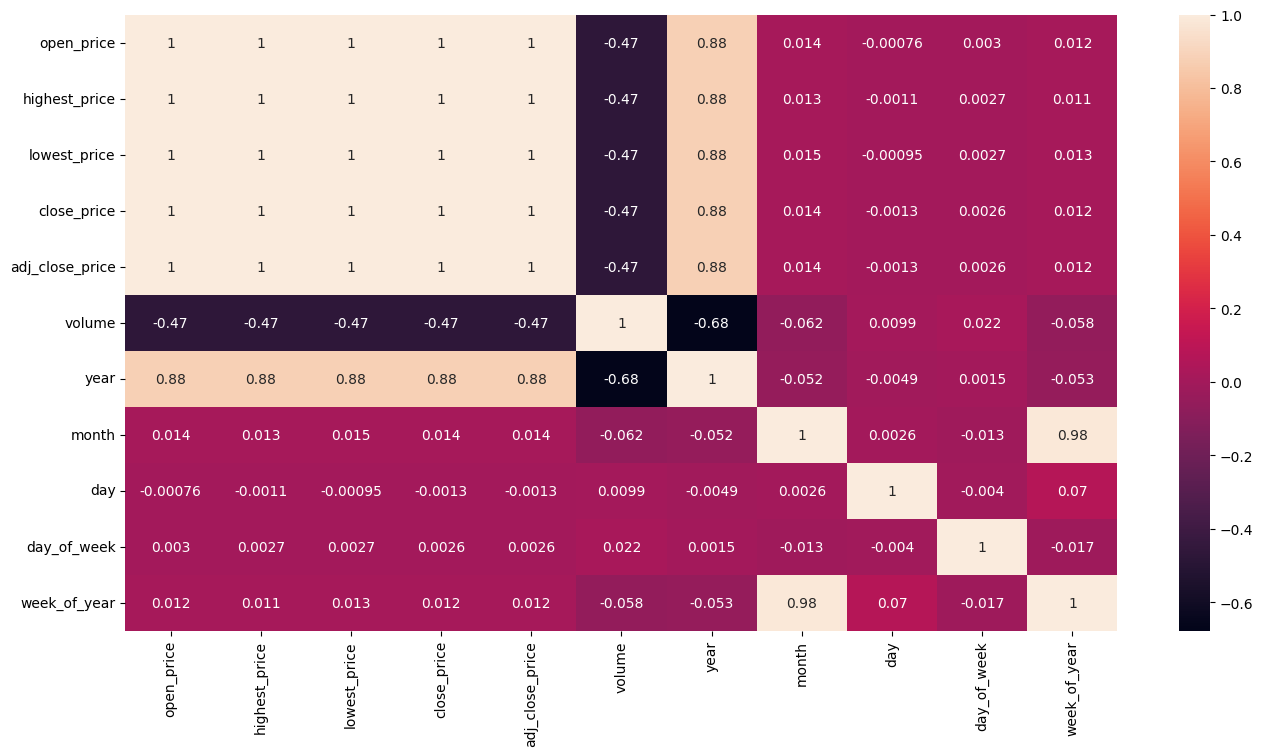

In [6]:
sns.heatmap(meta.corr(), annot=True)

In [7]:
meta

open_price  highest_price  lowest_price  close_price  \
date                                                               
2004-08-19    2.490664       2.591785      2.390042     2.499133   
2004-08-20    2.515820       2.716817      2.503118     2.697639   
2004-08-23    2.758411       2.826406      2.716070     2.724787   
2004-08-24    2.770615       2.779581      2.579581     2.611960   
2004-08-25    2.614201       2.689918      2.587302     2.640104   
...                ...            ...           ...          ...   
2024-02-02  140.889999     143.880005    138.169998   143.539993   
2024-02-05  144.039993     146.669998    143.910004   144.929993   
2024-02-06  145.960007     146.740005    144.520004   145.410004   
2024-02-07  146.119995     147.000000    145.210007   146.679993   
2024-02-08  146.970001     147.610001    146.419998   147.220001   

            adj_close_price     volume  year  month  day  day_of_week  \
date                                                                    
2004-08-19         2.499133  897427216  2004      8   19            3   
2004-08-20         2.697639  458857488  2004      8   20            4   
2004-08-23         2.724787  366857939  2004      8   23            0   
2004-08-24         2.611960  306396159  2004      8   24            1   
2004-08-25         2.640104  184645512  2004      8   25            2   
...                     ...        ...   ...    ...  ...          ...   
2024-02-02       143.539993   42116900  2024      2    2            4   
2024-02-05       144.929993   29254400  2024      2    5            0   
2024-02-06       145.410004   21517700  2024      2    6            1   
2024-02-07       146.679993   21436100  2024      2    7            2   
2024-02-08       147.220001   18219900  2024      2    8            3   

            week_of_year  
date                      
2004-08-19            34  
2004-08-20            34  
2004-08-23            35  
2004-08-24            35  
2004-08-25            35  
...                  ...  
2024-02-02             5  
2024-02-05             6  
2024-02-06             6  
2024-02-07             6  
2024-02-08             6  

[4902 rows x 11 columns]

In [8]:
from sklearn.ensemble import RandomForestRegressor

import xgboost
from xgboost import XGBRegressor

In [9]:
model_xgb = XGBRegressor(**{
    'n_estimators': 500,
    'n_jobs': -1,
    'max_depth': 6,
    'eta': 0.3,
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': 1,
    'colsample_bytree': 1,
    'min_child_weight': 1,
    'random_state': 7,
})

In [10]:
# X_train = meta.loc[:'2023-10-01', list(set(meta.columns)-set(['close_price', 'adj_close_price']))]
X_train = meta.loc[:'2023-10-01', ['open_price', 'year', 'month', 'day', 'day_of_week', 'week_of_year']]
y_train = meta.loc[:'2023-10-01', ['close_price']]

# X_test = meta.loc['2023-10-01':, list(set(meta.columns)-set(['close_price', 'adj_close_price']))]
X_test = meta.loc['2023-10-01':, ['open_price', 'year', 'month', 'day', 'day_of_week', 'week_of_year']]
y_test = meta.loc['2023-10-01':, ['close_price']]

y_pred = model_xgb.fit(X_train, y_train).predict(X_test)

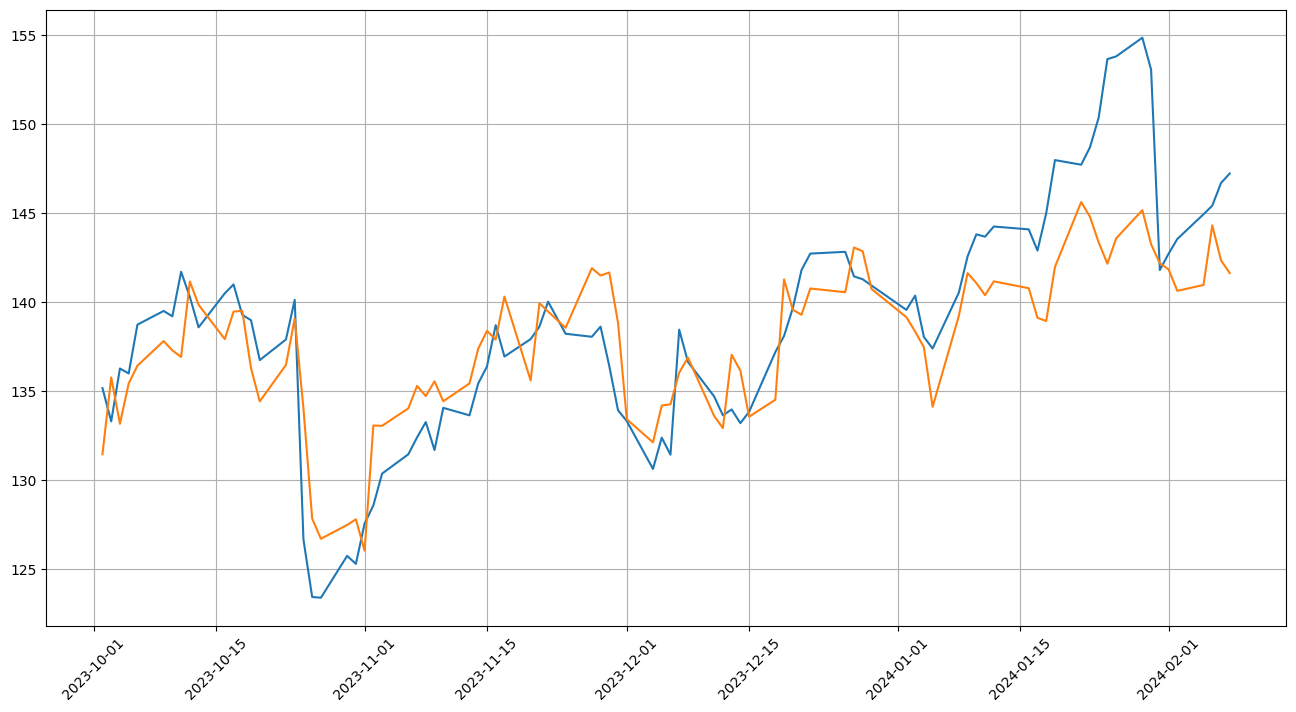

In [11]:
y_pred_df = pd.DataFrame(y_pred, index=y_test.index)

plt.plot(meta.loc['2023-10':, ['close_price']])
plt.plot(y_pred_df)
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [12]:
err = pd.DataFrame({
    'abs_err': abs(y_pred_df[0] - y_test['close_price']),
    'rel_err': abs(y_pred_df[0] / y_test['close_price'] - 1) * 100
})
err.mean()

abs_err    2.756814
rel_err    1.965409
dtype: float64

In [13]:
# X_train = meta.loc[:'2023-10-01', list(set(meta.columns)-set(['close_price', 'adj_close_price']))]
X_train = meta.loc[:'2023-10-01', ['open_price', 'highest_price', 'lowest_price', 'close_price', 'year', 'month', 'day', 'day_of_week', 'week_of_year']]
y_train = meta.loc[:'2023-10-01', ['volume']]

# X_test = meta.loc['2023-10-01':, list(set(meta.columns)-set(['close_price', 'adj_close_price']))]
X_test = meta.loc['2023-10-01':, ['open_price', 'highest_price', 'lowest_price', 'close_price', 'year', 'month', 'day', 'day_of_week', 'week_of_year']]
y_test = meta.loc['2023-10-01':, ['volume']]

y_pred = model_xgb.fit(X_train, y_train).predict(X_test)

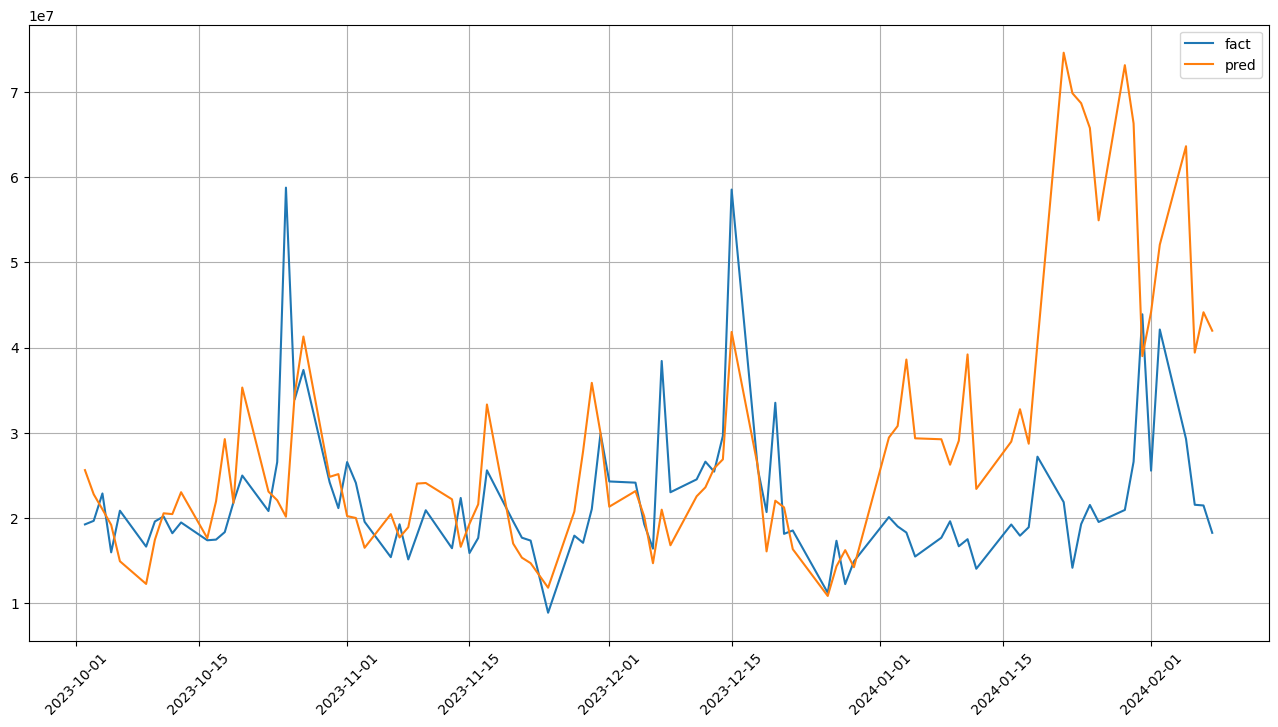

In [14]:
y_pred_df = pd.DataFrame(y_pred, index=y_test.index)

plt.plot(y_test, label='fact')
plt.plot(y_pred_df, label='pred')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

In [15]:
err = pd.DataFrame({
    'abs_err': abs(y_pred_df[0] - y_test['volume']),
    'rel_err': abs(y_pred_df[0] / y_test['volume'] - 1) * 100
})
err

abs_err     rel_err
date                              
2023-10-02   6380506.0   33.213811
2023-10-03   3123420.0   15.912516
2023-10-04   1865390.0    8.164347
2023-10-05   3231852.0   20.296881
2023-10-06   5940380.0   28.533044
...                ...         ...
2024-02-02   9974208.0   23.682199
2024-02-05  34407404.0  117.614458
2024-02-06  17886344.0   83.123865
2024-02-07  22711276.0  105.948731
2024-02-08  23758732.0  130.399903

[90 rows x 2 columns]